In [83]:
from math import *
import numpy as np
from itertools import product,permutations
from scipy.integrate import quad
import matplotlib.pyplot as plt
import seaborn as sns
d = 1
limit = [-8,12]

In [2]:
def unit_mat(params,N,m):
    [theta,phi] = params
    M = np.zeros((N, N), dtype=complex)
    M[m,m] = -1j*np.exp(-1j*(theta/2))*np.exp(-1j*phi)*np.sin(theta/2)                     #u11
    M[m,m+1] = -1j*np.exp(-1j*(theta/2))*np.exp(-1j*phi)*np.cos(theta/2)                      #u12
    M[m+1,m] = -1j*np.exp(-1j*(theta/2))*np.cos(theta/2)                   #u21
    M[m+1,m+1] = -1j*np.exp(-1j*(theta/2))*-np.sin(theta/2)                   #u22
    for i in range(N):
        if M[i,i] ==0+0j and i!=m and i!=m+1:
            M[i,i]=1+0j
    return (M)

In [19]:
def unit_state_transform(u,s,p,t,c,tau):
    output_s = []
    output_p = []
    output_t = []
    for k in range(len(s)):
        temp_state = s[k]
#         comb = list(product(range(len(u)), repeat=len(u)))
        comb = list(product(range(len(u)), repeat=len(s[k])))

        for i in range(len(comb)):
            temp3 = p[k]
            temp_t = [i for i in t[k]]
            for j in range(len(comb[i])):
                temp3 = temp3*u[temp_state[j],comb[i][j]]
                if comb[i][j] == c:
                    temp_t[j] +=tau[0]
                if comb[i][j] == c+1:
                    temp_t[j] +=tau[1]
            if temp3 !=0:
                output_s.append(list(comb[i]))
                output_p.append(temp3)
                output_t.append(temp_t)
    return(output_s,output_p,output_t)

In [15]:
def photonic_transform(initial_state,pos_unit,params_unit,T,n_channel):
#     input_state = [list(range(n_channel))]
    input_state = initial_state
    input_prob = [1]
    input_time = T
    for i in range(len(pos_unit)):
        mat = unit_mat(params_unit[i][0:2],n_channel,pos_unit[i])
        mat = np.transpose(mat)
        input_state,input_prob,input_time = unit_state_transform(mat,input_state,input_prob,input_time,pos_unit[i],params_unit[i][2:])
        
    return(input_state,input_prob,input_time)

In [5]:
def id_state(temp1,pstate,time):
    temp2 = []
    ptemp = []
    time_temp = [] 
    l = len(temp1)
    while l >0:
        temp3 = temp1[0]
        temp4 = []
        temp5 = []
        for j in range(len(temp1)):
            if sorted(temp1[j]) == sorted(temp3):
                temp4.append(temp1[j])
                temp5.append(j)
        temp2.append(temp4)
        temp1 = [x for x in temp1 if (x not in temp4)]
        ptemp.append([pstate[x] for x in temp5])
        time_temp.append([time[x] for x in temp5])
        pstate = [pstate[x] for x in range(len(pstate)) if (x not in temp5)]
        time = [time[x] for x in range(len(time)) if (x not in temp5)]
        l = len(temp1)
    return(temp2,ptemp,time_temp)

In [6]:
def time_swap(state,time):
    temp_state = []
    temp_time = []
    for i in range(len(state)):
        temp_state.append(state[i][0])
        temp_ind_time = []
        for j in range(len(state[i])):
            temp = state[i][j]
            temp1 = state[i][0]
            temp2 = time[i][j]
            temp3 = []
            for k in range(len(temp)): 
                ind = temp.index(temp1[k])
                temp3.append(temp2[ind])
                temp = [temp[x] for x in range(len(temp)) if (x is not ind)]
                temp2 = [temp2[x] for x in range(len(temp2)) if (x is not ind)]
            temp_ind_time.append(temp3)
        temp_time.append(temp_ind_time)
    return(temp_state,temp_time)

In [7]:
def combs(state,prob,time):
    temp_time = []
    temp_prob = []
    for i in range(len(state)):
        se = state[i]
        if len(se) - len(set(se)) !=0:
            temp = list(permutations(list(range(len(se)))))
            temp1 = []
            for j in range(len(temp)):
                temp2 = []
                for k in range(len(temp[j])):
                    temp2.append(se[temp[j][k]])
                if temp2 == se:
                    temp1.append(temp[j])
            temp2 = []
            temp3 = []
            for j in range(len(time[i])):
                temp4 = time[i][j]
                temp5 = prob[i][j]
                for k in range(len(temp1)):
                    temp6 = []
                    for l in range(len(temp1[k])):
                        temp6.append(temp4[temp1[k][l]])
                    temp2.append(temp6)
                    temp3.append(temp5/len(temp1))
        else:
            temp2 = time[i]
            temp3 = prob[i]
        temp_time.append(temp2)
        temp_prob.append(temp3)
    return(state,temp_prob,temp_time)

## INTEGRATION

In [8]:
def epsl(t,a):
    result = (2*d**2/pi)**(1/4)*exp(-d**2*(a-t)**2)
    return(result)

In [9]:
def beta(X,T):
    result = 1
    for i in range(len(X)):
        result = result*epsl(X[i],T[i])
    return(result)

In [10]:
def integrate(n,T1,T2):
    step = 10000
    temp = limit[0]
    temp2 = 0
    x = limit[1]-limit[0]
    dtt = x/step
    X1 = T1[:]
    X2 = T2[:]
    for i in range(step):
        X1[n] = temp
        X2[n] = temp
        temp2 += beta(X1,T1)*beta(X2,T2)*(2*d**2/pi)**(-(len(T1)-1)/2)*dtt
        temp += dtt
    return(temp2)

In [11]:
def gama(time,prob):
    temp = 0
    temp2 = int(len(time[0]))
    for i in range(len(prob)):
        for j in range(len(prob)):
            multi = np.conj(prob[i])*prob[j]
            for k in range(temp2):
                multi = multi*integrate(k,time[i],time[j]) 
            temp+=multi
    
    return(temp)

In [12]:
def repetition_multiplier(state_with_copy):
    temp1 = list(set(state_with_copy))
    temp2 = 1
    for i in range(len(temp1)):
        temp2 = temp2*factorial(state_with_copy.count(temp1[i]))
    return(temp2)


In [76]:
def Probability(state,prob,time):
    result = {}
    temp2 = 0
    for i in range(len(state)):
        print(i)
        temp = gama(time[i],prob[i])*repetition_multiplier(state[i])
        result[str(state[i])] = temp
        temp2+=temp
    print(temp2)
    return(result)

## Calculation

In [263]:
temp1,pstate,time = photonic_transform([0,1],[[np.pi,np.pi,0,0],[np.pi/2,np.pi,0,0]],[[0,0,0]],3)
a , b , c = id_state(temp1,pstate,time)
a,c = time_swap(a,c)
a,b,c = combs(a,b,c)

In [264]:
Probability(a,b,c)

(0.9999999999999946+1.4243351618639698e-65j)


{'[0, 0, 1]': (3.749399456654622e-33+0j),
 '[0, 0, 2]': (3.749399456654622e-33+0j),
 '[0, 1, 1]': (0.49999999999999717+0j),
 '[0, 1, 2]': 0j,
 '[0, 2, 2]': (0.4999999999999974+0j),
 '[1, 1, 1]': (2.8120495924909686e-33+0j),
 '[1, 1, 2]': (9.373498641636547e-34+0j),
 '[1, 2, 2]': (9.37349864163655e-34+1.4243351618639698e-65j),
 '[2, 2, 2]': (2.81204959249097e-33+0j)}

In [101]:
def Probability_specific_state(state,prob,time,specific_state):
    ind = state.index(specific_state)
    temp = gama(time[ind],prob[ind])*repetition_multiplier(state[ind])
    return(temp)

In [266]:
p123 = [0]*51
Tim = np.linspace(-4,4,51)
lim = [-7,7]
for i in range(len(p123)):
    print(i)
    temp1,pstate,time = photonic_transform([0,1],[[np.pi,0,0,Tim[i]],[np.pi/2,0,0,0]],[[0,0,0]],3)
    a , b , c = id_state(temp1,pstate,time)
    a,c = time_swap(a,c)
    a,b,c = combs(a,b,c)
    p123[i] = Probability_specific_state(a,b,c,[0,1,2])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


c:\users\kevin\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


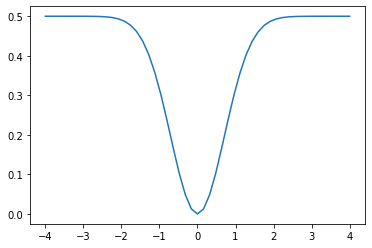

In [267]:
plt.plot(Tim, p123)

In [20]:
temp1,pstate,time = photonic_transform([[0,1]],[0,1],[[np.pi,np.pi,0,0],[np.pi/2,np.pi,0,0]],[[0,0,0]],3)
a , b , c = id_state(temp1,pstate,time)
a,c = time_swap(a,c)
a,b,c = combs(a,b,c)
Probability(a,b,c)

(0.9999999999999961+0j)


{'[0, 0]': (7.498798913309255e-33+0j),
 '[0, 1]': (0.499999999999998+0j),
 '[0, 2]': (0.4999999999999981+0j),
 '[1, 1]': (1.8746997283273145e-33+0j),
 '[1, 2]': (3.749399456654629e-33+0j),
 '[2, 2]': (1.8746997283273155e-33+0j)}

In [23]:
temp1,pstate,time = photonic_transform([[1,2]],[0,1],[[np.pi,np.pi,0,0],[np.pi/2,np.pi,0,0]],[[0,4]],3)
a , b , c = id_state(temp1,pstate,time)
a,c = time_swap(a,c)
a,b,c = combs(a,b,c)
Probability(a,b,c)

(1.0000000000001061+0j)


{'[0, 1]': (1.8746997283275204e-33+0j),
 '[0, 2]': (1.8746997283275204e-33+0j),
 '[1, 1]': (0.25000002813382005+0j),
 '[1, 2]': (0.4999999437324657+0j),
 '[2, 2]': (0.2500000281338203+0j)}

In [99]:
keys

['[0, 0]',
 '[0, 1]',
 '[1, 1]',
 '[0, 2]',
 '[0, 3]',
 '[1, 2]',
 '[1, 3]',
 '[2, 2]',
 '[2, 3]',
 '[3, 3]',
 '[0, 4]',
 '[0, 5]',
 '[1, 4]',
 '[1, 5]',
 '[2, 4]',
 '[2, 5]',
 '[3, 4]',
 '[3, 5]',
 '[4, 4]',
 '[4, 5]',
 '[5, 5]']

In [108]:
p13 = [0]*19
Tim = np.linspace(-4,4,19)
lim = [-7,7]
for i in range(len(p13)):
    print(i)
    temp1,pstate,time = photonic_transform([[3,4]],[3,2,4,1,3,5,0,2,4,6],[[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0]],[[0,Tim[i]]],8)
    a , b , c = id_state(temp1,pstate,time)
    a,c = time_swap(a,c)
    a,b,c = combs(a,b,c)
    p13[i] = Probability_specific_state(a,b,c,[1,3])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


c:\users\kevin\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


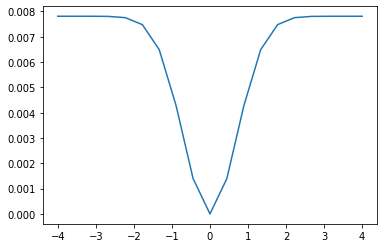

In [105]:
plt.plot(Tim, p13)

In [106]:
p11 = [0]*19
Tim = np.linspace(-4,4,19)
lim = [-7,7]
for i in range(len(p11)):
    print(i)
    temp1,pstate,time = photonic_transform([[3,4]],[3,2,4,1,3,5,0,2,4,6],[[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0]],[[0,Tim[i]]],8)
    a , b , c = id_state(temp1,pstate,time)
    a,c = time_swap(a,c)
    a,b,c = combs(a,b,c)
    p11[i] = Probability_specific_state(a,b,c,[1,1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


c:\users\kevin\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


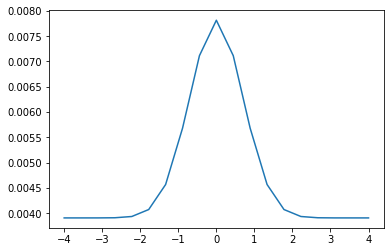

In [107]:
plt.plot(Tim, p11)

In [109]:
temp1,pstate,time = photonic_transform([[3,4]],[3,2,4,1,3,5,0,2,4,6],[[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0]],[[0,4]],8)
a , b , c = id_state(temp1,pstate,time)
a,c = time_swap(a,c)
a,b,c = combs(a,b,c)
result = Probability(a,b,c)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
(1.0000000000001086-4.285194082914587e-33j)


In [110]:
heatmap_data1 = np.zeros([8,8])
for i in range(len(keys)):
    heatmap_data1[int(keys[i][1]),int(keys[i][4])] = result[keys[i]]
    heatmap_data1[int(keys[i][4]),int(keys[i][1])] = result[keys[i]]

<ipython-input-110-6d1e696b248d>:3: ComplexWarning: Casting complex values to real discards the imaginary part
  heatmap_data1[int(keys[i][1]),int(keys[i][4])] = result[keys[i]]
<ipython-input-110-6d1e696b248d>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  heatmap_data1[int(keys[i][4]),int(keys[i][1])] = result[keys[i]]


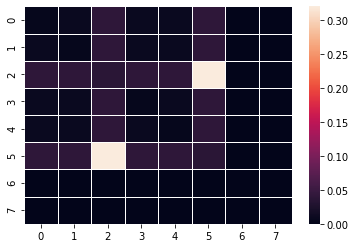

In [111]:
ax = sns.heatmap(heatmap_data1, linewidth=0.5)
plt.show()

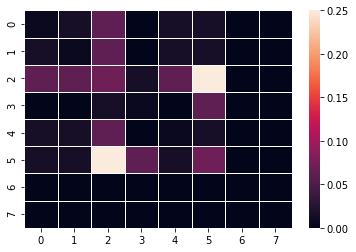

In [113]:
ax = sns.heatmap(heatmap_data, linewidth=0.5)
plt.show()

In [115]:
temp1,pstate,time = photonic_transform([[3,4]],[3,2,4,1,3,5,0,2,4,6],[[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0],[np.pi/2,np.pi,0,0]],[[0,0]],8)
a , b , c = id_state(temp1,pstate,time)
a,c = time_swap(a,c)
a,b,c = combs(a,b,c)
result = Probability(a,b,c)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


KeyboardInterrupt: 

In [ ]:
heatmap_data2 = np.zeros([8,8])
for i in range(len(keys)):
    heatmap_data2[int(keys[i][1]),int(keys[i][4])] = result[keys[i]]
    heatmap_data2[int(keys[i][4]),int(keys[i][1])] = result[keys[i]]    
ax = sns.heatmap(heatmap_data2, linewidth=0.5)
plt.show()